# SolsysGen & WaterIO
## Project presentation notebook (tutorial + demo)

This notebook is a guided demo of:

- **SolsysGen**: deterministic heliocentric systems (**2D circular Keplerian orbits**)
- **WaterIO**: checkpointing NumPy arrays to compressed **`.npz`** files

It is suitable for:

- a **10–15 minute** walkthrough (course presentation)
- a reproducible, runnable tutorial

---

### Roadmap

1. Imports and setup  
2. Build a minimal system (procedural generation)  
3. Visualize orbits (figures)  
4. Time stepping + tracking (figures)  
5. Kepler formulas (equations)  
6. JSON roundtrip  
7. WaterIO checkpoint roundtrip (figures)  
8. Optional native/Cython smoke check  


---

## 1. Imports and setup

Run this once to import the public APIs and basic plotting tools.


In [1]:
from __future__ import annotations

import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from solsysgen import SolarSystem, Sun, generate_planets
from solsysgen.constants import AU_M, DAY_S, YEAR_S
from solsysgen.io import load_json, save_json
from solsysgen.kepler import circular_speed_mps, period_s
from waterio import load_checkpoint, save_checkpoint

# Output directory for generated files (JSON + NPZ)
OUT_DIR = Path("_demo_outputs")
OUT_DIR.mkdir(exist_ok=True)

print("Setup OK. Output dir:", OUT_DIR.resolve())


Setup OK. Output dir: /home/torun/Desktop/cyrus/PHD 2024 second year/courses/python3/_demo_outputs


---

## 2. Conceptual overview (what the project does)

### SolsysGen (simulation)
SolsysGen models a simple heliocentric system:

- circular, coplanar **2D** orbits
- explicit time stepping (`SolarSystem.step(dt)`)
- deterministic procedural generation (`generate_planets(...)`)
- clarity over realism (no N-body gravity, no perturbations)

Core objects:

- `Sun` (central body)
- `Planet` (orbital distance + phase; speed/period derived from Kepler)
- `SolarSystem` (container; stepping + serialization)

### WaterIO (checkpointing)
WaterIO provides helpers for saving/loading NumPy arrays:

- `save_checkpoint(path, **arrays)`
- `load_checkpoint(path) -> dict[str, np.ndarray]`

Useful for storing simulation outputs such as **positions over time**.


---

## 3. Minimal generated system

Create a Sun, generate planets deterministically, and inspect the result.


In [2]:
sun = Sun()
planets = generate_planets(sun, 5, seed=1, inner_au=0.6, outer_au=12.0)
system = SolarSystem(sun=sun, planets=planets)

len(system), [p.name for p in system.planets]


(5, ['Planet 1', 'Planet 2', 'Planet 3', 'Planet 4', 'Planet 5'])

### 3.1 Summary table (as Python objects)

Distances are shown in AU, periods in days/years.


In [3]:
rows = []
for p in system.planets:
    rows.append(
        {
            "name": p.name,
            "kind": p.kind,
            "a_AU": p.distance_m / AU_M,
            "T_days": p.period_s / DAY_S,
            "T_years": p.period_s / YEAR_S,
            "v_kms": p.orbital_speed_mps / 1000.0,
        }
    )

rows


[{'name': 'Planet 1',
  'kind': 'rocky',
  'a_AU': 0.5648989674347905,
  'T_days': 155.07605907320507,
  'T_years': 0.4245751103989187,
  'v_kms': 39.62940601981198},
 {'name': 'Planet 2',
  'kind': 'rocky',
  'a_AU': 1.2679187690446916,
  'T_days': 521.4656797289317,
  'T_years': 1.427695221708232,
  'v_kms': 26.45192228472813},
 {'name': 'Planet 3',
  'kind': 'gas_giant',
  'a_AU': 2.5089153191022766,
  'T_days': 1451.5018354559395,
  'T_years': 3.973995442726734,
  'v_kms': 18.80442039709938},
 {'name': 'Planet 4',
  'kind': 'gas_giant',
  'a_AU': 5.912576873724587,
  'T_days': 5251.1422717835185,
  'T_years': 14.376844002145157,
  'v_kms': 12.249392572787457},
 {'name': 'Planet 5',
  'kind': 'ice_giant',
  'a_AU': 11.479223464839274,
  'T_days': 14205.527001255798,
  'T_years': 38.8926132820145,
  'v_kms': 8.791170404016494}]

### 3.2 Figure: orbital radii distribution

Procedural generation uses roughly log-spaced orbital distances.


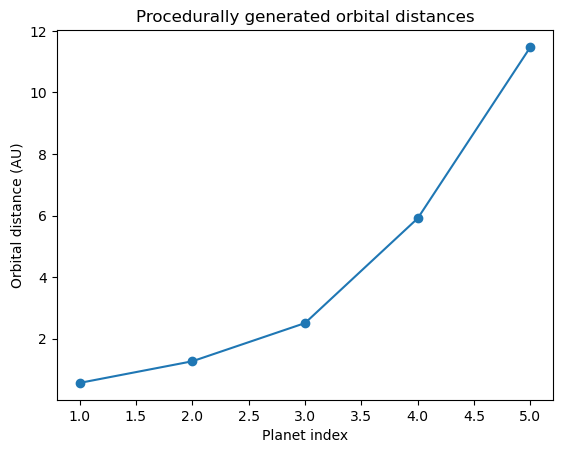

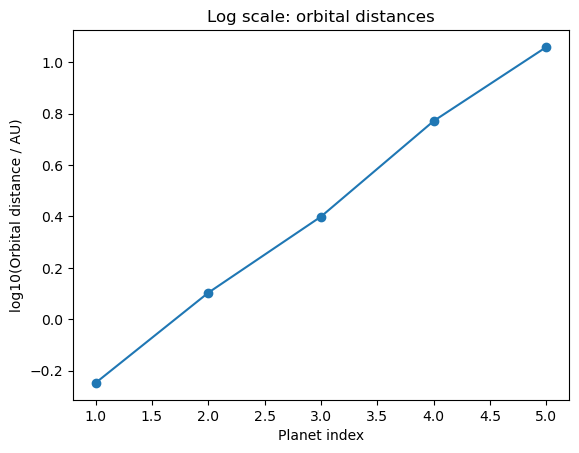

In [4]:
a_au = np.array([p.distance_m / AU_M for p in system.planets], dtype=float)

plt.figure()
plt.plot(range(1, len(a_au) + 1), a_au, marker="o")
plt.xlabel("Planet index")
plt.ylabel("Orbital distance (AU)")
plt.title("Procedurally generated orbital distances")
plt.show()

plt.figure()
plt.plot(range(1, len(a_au) + 1), np.log10(a_au), marker="o")
plt.xlabel("Planet index")
plt.ylabel("log10(Orbital distance / AU)")
plt.title("Log scale: orbital distances")
plt.show()


---

## 4. Figure: orbit visualization (x–y plane)

Because orbits are circular in this project, the path should form a circle at radius `a`.
We sample multiple time steps and plot trajectories.


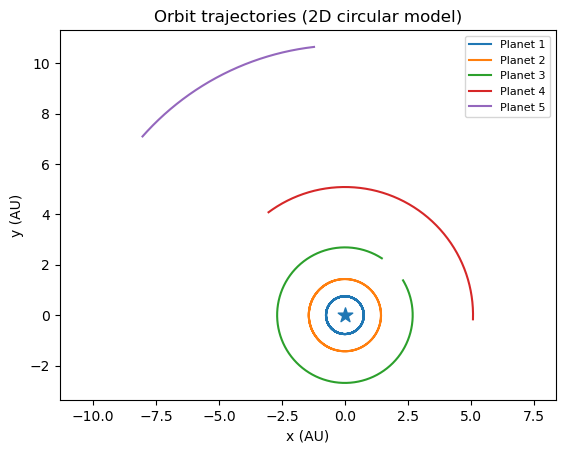

In [5]:
# Fresh system to plot clean trajectories from t=0
sun_viz = Sun()
planets_viz = generate_planets(sun_viz, 5, seed=2, inner_au=0.7, outer_au=10.0)
system_viz = SolarSystem(sun=sun_viz, planets=planets_viz)

n_steps = 300
dt = 5 * DAY_S

traj = np.zeros((n_steps, len(planets_viz), 2), dtype=np.float64)

for t in range(n_steps):
    for i, p in enumerate(system_viz.planets):
        traj[t, i, :] = p.position_m()
    system_viz.step(dt)

plt.figure()
for i, p in enumerate(system_viz.planets):
    plt.plot(traj[:, i, 0] / AU_M, traj[:, i, 1] / AU_M, label=p.name)

plt.scatter([0], [0], marker="*", s=120)  # Sun at origin
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Orbit trajectories (2D circular model)")
plt.axis("equal")
plt.legend(loc="upper right", fontsize=8)
plt.show()


---

## 5. Time stepping and orbit tracking

Pick one planet and track its position and radius across time steps.


In [6]:
# Fresh system for tracking
sun_track = Sun()
planets_track = generate_planets(sun_track, 5, seed=1, inner_au=0.6, outer_au=12.0)
system_track = SolarSystem(sun=sun_track, planets=planets_track)

target = system_track.planets[len(system_track.planets) // 2]
target.name, target.kind, target.distance_m / AU_M


('Planet 3', 'gas_giant', 2.5089153191022766)

In [7]:
steps = 120
dt = 10 * DAY_S

track_xy = np.zeros((steps + 1, 2), dtype=np.float64)
t_days = np.zeros((steps + 1,), dtype=np.float64)

t = 0.0
for i in range(steps + 1):
    x, y = target.position_m()
    track_xy[i, :] = (x, y)
    t_days[i] = t / DAY_S
    system_track.step(dt)
    t += dt

track_xy[:3], t_days[:3]


(array([[-3.42334220e+11,  1.53878789e+11],
        [-3.48672481e+11,  1.38920485e+11],
        [-3.54357499e+11,  1.23701911e+11]]),
 array([ 0., 10., 20.]))

### 5.1 Figure: radius vs time (sanity check)

For a perfect circular orbit, the radius should stay constant.


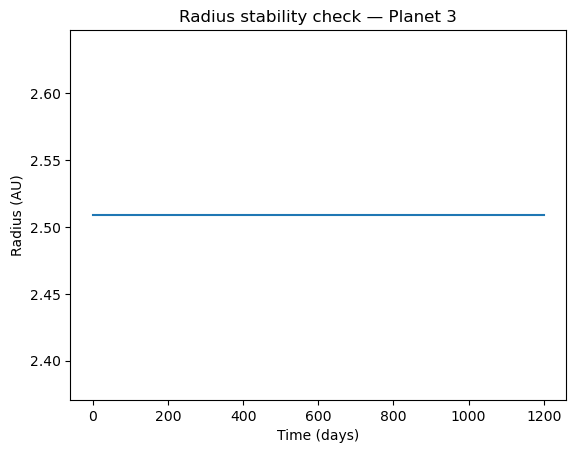

(2.5089153191022766, 2.508915319102277, 2.5089153191022766)

In [8]:
r = np.sqrt(track_xy[:, 0] ** 2 + track_xy[:, 1] ** 2)

plt.figure()
plt.plot(t_days, r / AU_M)
plt.xlabel("Time (days)")
plt.ylabel("Radius (AU)")
plt.title(f"Radius stability check — {target.name}")
plt.show()

float(r.min() / AU_M), float(r.max() / AU_M), float(r.mean() / AU_M)


---

## 6. Kepler helpers (equations + direct evaluation)

SolsysGen uses Kepler’s third law for circular two-body orbits.

### Equations

For a planet at orbital radius \(a\) around a star of mass \(M\):

$$
T = 2\pi \sqrt{\frac{a^3}{G M}}
$$

Circular orbital speed:

$$
v = \sqrt{\frac{G M}{a}}
$$

These are implemented in:

- `period_s(a_m, M_kg)`
- `circular_speed_mps(a_m, M_kg)`


In [9]:
a = 1.0 * AU_M
T = period_s(a, sun.mass_kg)
v = circular_speed_mps(a, sun.mass_kg)

print("For a = 1 AU:")
print("  Period (days):", T / DAY_S)
print("  Period (years):", T / YEAR_S)
print("  Speed (km/s):", v / 1000.0)


For a = 1 AU:
  Period (days): 365.2486206062388
  Period (years): 0.999996223425705
  Speed (km/s): 29.785366852242355


---

## 7. JSON export + reload roundtrip

Export a system to JSON and reload it, verifying basic invariants.


In [10]:
json_path = OUT_DIR / "system.json"
save_json(json_path, system)

loaded = load_json(json_path)

print("Wrote:", json_path)
print("Planet count preserved:", len(system.planets), "->", len(loaded.planets))
print("Kinds preserved:", [p.kind for p in system.planets] == [p.kind for p in loaded.planets])


Wrote: _demo_outputs/system.json
Planet count preserved: 5 -> 5
Kinds preserved: True


---

## 8. WaterIO checkpointing with NumPy (.npz)

Save a `(time, planet, xy)` position cube to `.npz`, reload it, and verify integrity.


In [11]:
# Fresh system so we start from a clean phase
sun2 = Sun()
planets2 = generate_planets(sun2, 4, seed=3, inner_au=0.7, outer_au=6.0)
system2 = SolarSystem(sun=sun2, planets=planets2)

steps = 200
dt = 5 * DAY_S

pos = np.zeros((steps, len(planets2), 2), dtype=np.float64)
for t in range(steps):
    for i, p in enumerate(system2.planets):
        pos[t, i, :] = p.position_m()
    system2.step(dt)

ckpt_path = OUT_DIR / "positions_ckpt.npz"
save_checkpoint(ckpt_path, positions=pos, dt_days=np.array([dt / DAY_S]))

loaded_ckpt = load_checkpoint(ckpt_path)

print("Wrote:", ckpt_path)
print("Keys:", list(loaded_ckpt.keys()))
print("positions shape:", loaded_ckpt["positions"].shape)


Wrote: _demo_outputs/positions_ckpt.npz
Keys: ['positions', 'dt_days']
positions shape: (200, 4, 2)


### 8.1 Figure: trajectories from checkpoint

We reload the checkpoint and plot trajectories again.


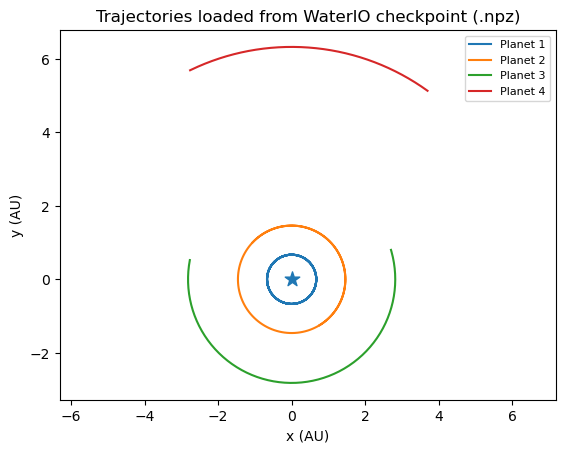

In [12]:
pos_loaded = loaded_ckpt["positions"]

plt.figure()
for i, p in enumerate(planets2):
    plt.plot(pos_loaded[:, i, 0] / AU_M, pos_loaded[:, i, 1] / AU_M, label=p.name)

plt.scatter([0], [0], marker="*", s=120)
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Trajectories loaded from WaterIO checkpoint (.npz)")
plt.axis("equal")
plt.legend(loc="upper right", fontsize=8)
plt.show()


---

## 9. Optional: native/Cython extension smoke check

Your repository may include optional compiled extensions.  
This cell checks whether they are importable (**it is OK if not**).


In [13]:
try:
    from solsysgen import planet as planet_ext  # type: ignore

    print("SolsysGen optional extension available:", planet_ext)
except Exception as e:
    print("SolsysGen optional extension not available (OK).")
    print("Reason:", repr(e))

try:
    import waterio._fast as waterio_fast  # type: ignore

    print("WaterIO optional extension available:", waterio_fast)
except Exception as e:
    print("WaterIO optional extension not available (OK).")
    print("Reason:", repr(e))


SolsysGen optional extension available: <module 'solsysgen.planet' from '/home/torun/Desktop/cyrus/PHD 2024 second year/courses/python3/src/solsysgen/planet.py'>
WaterIO optional extension available: <module 'waterio._fast' from '/home/torun/Desktop/cyrus/PHD 2024 second year/courses/python3/src/waterio/_fast.cpython-314-x86_64-linux-gnu.so'>


---

## Summary

- **SolsysGen** builds deterministic heliocentric systems with simple circular Keplerian orbits.
- Systems can be stepped forward in time and positions inspected/visualized.
- Systems can be exported to JSON and reloaded.
- **WaterIO** stores NumPy checkpoint arrays to compressed `.npz` for reproducibility.

### Presentation tip
For a short presentation, run the notebook top-to-bottom once and then present:
- Section 4 (orbits figure)
- Section 6 (equations)
- Section 8 (checkpoint + figure)
